<a href="https://colab.research.google.com/github/khlose/homl_ageron/blob/master/classification_ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD MNIST


In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")


# Exploring data

In [3]:

X,y = mnist['data'],mnist['target']

print("X:" , X.shape , " Y: " , y.shape)

X: (70000, 784)  Y:  (70000,)


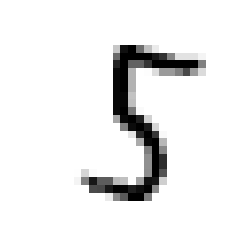

Index 5200 is a hand-written of number:  6


In [4]:
#Print out number
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

some_digit = X[3500]
some_digit_img = some_digit.reshape(28,28)

plt.imshow(some_digit_img, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print("Index 5200 is a hand-written of number: ", y[52000])

#Splitting Data
(Mnist data has already bee splitted into train and test in 60K- 10K ratio)

In [0]:
X_train, X_test, y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#shuffle as well (ensuring that cross validation fold will be even across all folds)

import numpy as np

shuffle_index = np.random.permutation(60000)

X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

#Simple binary classifier


In [6]:
# basically a detector that separate 5 and non-5 digit

y_train_5 = y_train == '5'
y_test_5 = y_test == '5'


from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
#predict
sgd_clf.predict([some_digit])

array([ True])

# SGD performance measure


In [9]:
# We need more contol over cross-validation process
# Implement it myself

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits =3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]
  
  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  
  n_correct = sum(y_pred == y_test_folds)
  
  print(n_correct/len(y_pred))

0.9643
0.96405
0.95305


In [11]:
#premade cross_val_score

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9643 , 0.96405, 0.95305])